# 0. Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import warnings

warnings.filterwarnings("ignore")
sns.set_palette("husl")
plt.style.use('seaborn-v0_8')
%matplotlib inline

# 1. Data preparation

## 1.1 Downloading data

In [2]:
extended_rfm = pd.read_csv('../data/customer_features.csv')
print(f"Data uploaded: {extended_rfm.shape[0]:,} customers, {extended_rfm.shape[1] - 1} features")

Data uploaded: 4,338 customers, 14 features


In [3]:
extended_rfm.head()

,CustomerID,Recency,Frequency,Monetary,NumOrders,NumUniqueProducts,TotalQuantity,AvgQuantity,TotalSpent,AvgOrderValue,StdOrderValue,FirstPurchase,LastPurchase,MainCountry,CustomerLifespan
0,12346,326,1,77183.60,1,1,74215,74215.00,77183.60,77183.60,NaN,2011-01-18 10:01:00,2011-01-18 10:01:00,United Kingdom,0
1,12347,2,7,4310.00,7,103,2458,13.51,4310.00,23.68,23.29,2010-12-07 14:57:00,2011-12-07 15:52:00,Iceland,365
2,12348,75,4,1797.24,4,22,2341,75.52,1797.24,57.98,48.51,2010-12-16 19:09:00,2011-09-25 13:13:00,Finland,282
3,12349,19,1,1757.55,1,73,631,8.64,1757.55,24.08,34.66,2011-11-21 09:51:00,2011-11-21 09:51:00,Italy,0
4,12350,310,1,334.40,1,17,197,11.59,334.40,19.67,7.28,2011-02-02 16:01:00,2011-02-02 16:01:00,Norway,0


## 1.2 Select key features for clustering

In [4]:
clustering_features = ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'NumUniqueProducts', 'CustomerLifespan']
X = extended_rfm[clustering_features].copy()

In [5]:
# Processing NaN and inf values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

In [6]:
X

,Recency,Frequency,Monetary,AvgOrderValue,NumUniqueProducts,CustomerLifespan
0,326,1,77183.60,77183.60,1,0
1,2,7,4310.00,23.68,103,365
2,75,4,1797.24,57.98,22,282
3,19,1,1757.55,24.08,73,0
4,310,1,334.40,19.67,17,0
...,...,...,...,...,...,...
4333,278,1,180.60,18.06,10,0
4334,181,1,80.82,11.55,7,0
4335,8,2,178.05,14.84,12,118
4336,4,16,2045.53,2.84,263,333


## 1.3 Data standardisation

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.33457414e+00, -4.25096503e-01,  8.36301037e+00,
         5.25397828e+01, -7.08801901e-01, -9.88064772e-01],
       [-9.05340320e-01,  3.54416797e-01,  2.51698905e-01,
        -3.04558489e-02,  4.86180191e-01,  1.77657708e+00],
       [-1.75359593e-01, -3.53398530e-02, -2.79878269e-02,
        -7.08673203e-03, -4.62776177e-01,  1.14790510e+00],
       ...,
       [-8.45341904e-01, -2.95177619e-01, -2.08214334e-01,
        -3.64786766e-02, -5.79931284e-01, -9.42901465e-02],
       [-8.85340848e-01,  1.52368675e+00, -3.51515172e-04,
        -4.46544610e-02,  2.36066191e+00,  1.53419752e+00],
       [-4.95351144e-01, -1.65258736e-01, -2.35311112e-02,
        -2.87048684e-02, -2.93022801e-02,  2.08684303e-01]],
      shape=(4338, 6))

## 1.5 Determining the optimal number of clusters (Elbow + Silhouette)

Elbow Method - focuses on internal compactness. The more clusters you define, the less internal dispersion (Inertia), i.e. objects within clusters become more similar. kmeans.inertia_ - the sum of the squared distances from each point to the centre of its cluster (in other words, the ‘scattering’ within clusters)
X: number of clusters k, Y: Inertia, Optimal k - where the graph ‘breaks’ and begins to flatten (elbow)

Silhouette Score - evaluates the quality of clusters in terms of the distances between them. It estimates how well each point fits into its cluster and how far it is from other clusters.
X: number of clusters k, Y: average Silhouette Score, Optimal k - where the score is maximum (but not always the highest!)

____________________________________________
Elbow Method (Метод ліктя) — зосереджений на внутрішній компактності. Чим більше кластерів ти задаєш, тим менше внутрішня дисперсія (Inertia) — тобто об'єкти всередині кластерів стають більш схожими. kmeans.inertia_ — сума квадратів відстаней від кожної точки до центру свого кластеру (іншими словами — «розсіювання» всередині кластерів)
X: кількість кластерів k, Y: Inertia, Оптимальне k — де графік «переламується» і починає вирівнюватись (лікоть)

Silhouette Score — оцінює якість кластерів з точки зору відстаней між ними. Оцінка наскільки добре кожна точка вписується в свій кластер і наскільки далеко вона від інших кластерів.
X: кількість кластерів k, Y: середній Silhouette Score, Оптимальне k — де score максимальний (але не завжди найбільше!)

  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


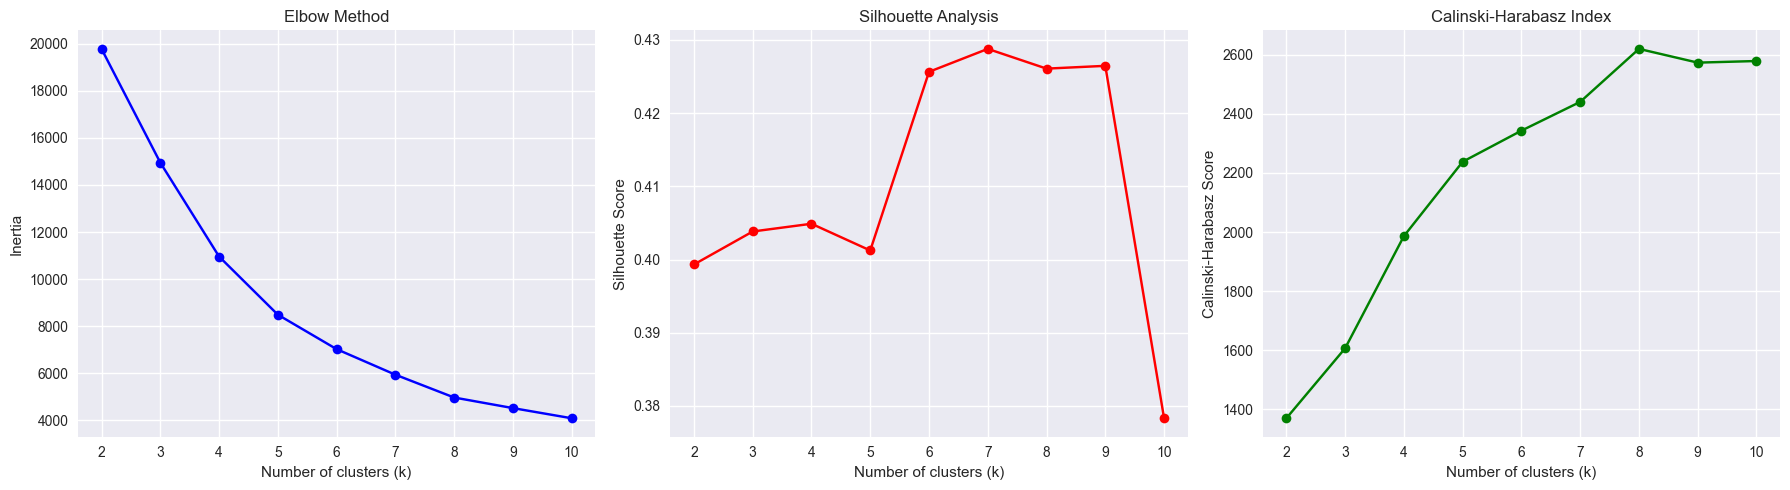

In [8]:
## Elbow Method + Silhouette Analysis for K-Means
k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))

# Visualisation of results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True)

# Calinski-Harabasz plot
axes[2].plot(k_range, calinski_scores, 'go-')
axes[2].set_xlabel('Number of clusters (k)')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Calinski-Harabasz Index')
axes[2].grid(True)

plt.tight_layout()

In [10]:
for k, inertia, silhouette in zip(k_range, inertias, silhouette_scores):
    print(f"k={k}: Inertia={inertia:.2f}, Silhouette={silhouette:.3f}")

# Selection of optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters by Silhouette Score: {optimal_k}")

k=2: Inertia=19778.62, Silhouette=0.399
k=3: Inertia=14947.12, Silhouette=0.404
k=4: Inertia=10959.32, Silhouette=0.405
k=5: Inertia=8489.17, Silhouette=0.401
k=6: Inertia=7025.95, Silhouette=0.426
k=7: Inertia=5940.91, Silhouette=0.429
k=8: Inertia=4971.46, Silhouette=0.426
k=9: Inertia=4522.15, Silhouette=0.426
k=10: Inertia=4090.69, Silhouette=0.378

Optimal number of clusters by Silhouette Score: 7


# 2. Clustering

## 2.1 Selection of clustering algorithm

In [11]:
algorithms_results = {}

### 2.1.1 K-Means

In [12]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

algorithms_results['K-Means'] = {
    'labels': kmeans_labels,
    'silhouette': silhouette_score(X_scaled, kmeans_labels),
    'calinski': calinski_harabasz_score(X_scaled, kmeans_labels),
    'davies_bouldin': davies_bouldin_score(X_scaled, kmeans_labels),
    'n_clusters': len(np.unique(kmeans_labels))
}

### 2.1.2 Hierarchical Clustering (Agglomerative)

In [13]:
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

algorithms_results['Hierarchical'] = {
    'labels': hierarchical_labels,
    'silhouette': silhouette_score(X_scaled, hierarchical_labels),
    'calinski': calinski_harabasz_score(X_scaled, hierarchical_labels),
    'davies_bouldin': davies_bouldin_score(X_scaled, hierarchical_labels),
    'n_clusters': len(np.unique(hierarchical_labels))
}

### 2.1.3 DBSCAN (parameter selection)

In [14]:
# Finding the optimal eps for DBSCAN
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sorting distances
distances = np.sort(distances[:,3], axis=0)

# Different eps values
eps_values = [0.5, 0.7, 1.0, 1.2, 1.5]
best_dbscan = None
best_silhouette = -1

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    if n_clusters > 1: 
        try:
            silhouette = silhouette_score(X_scaled, dbscan_labels)
            print(f"eps={eps}: clusters={n_clusters}, noises={n_noise}, silhouette={silhouette:.3f}")
            
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_dbscan = dbscan_labels
        except:
            print(f"eps={eps}: failed to calculate the silhouette score")
    else:
        print(f"eps={eps}: too few clusters ({n_clusters})")

if best_dbscan is not None:
    algorithms_results['DBSCAN'] = {
        'labels': best_dbscan,
        'silhouette': silhouette_score(X_scaled, best_dbscan),
        'calinski': calinski_harabasz_score(X_scaled, best_dbscan),
        'davies_bouldin': davies_bouldin_score(X_scaled, best_dbscan),
        'n_clusters': len(set(best_dbscan)) - (1 if -1 in best_dbscan else 0)
    }

eps=0.5: clusters=3, noises=202, silhouette=0.404
eps=0.7: too few clusters (1)
eps=1.0: too few clusters (1)
eps=1.2: too few clusters (1)
eps=1.5: too few clusters (1)


### 2.1.4 Comparison of the results of the algorithms

Clustering Quality Metrics<br>
1. Silhouette Score - Measures how well each point fits within its assigned cluster. A high Silhouette Score indicates well-separated clusters.Values range from -1 to 1: 1 — perfect clustering (point is well within its cluster and far from others); 0 — point lies on the border between clusters; <0 — point may be assigned to the wrong cluster.<br>

2. Calinski-Harabasz Index - Measures the ratio of between-cluster dispersion to within-cluster dispersion. The higher the value, the more distinct the clusters. Suitable for high-dimensional datasets.

3. Davies-Bouldin Score - Evaluates the average similarity between each cluster and the most similar one. Measures the density and distance between clusters. Lower values indicate better clustering (less overlap between clusters).

To choose the best clustering algorithm, we aim for:
- Highest **Silhouette Score**
- Highest **Calinski-Harabasz Index**
- Lowest **Davies-Bouldin Score**
______________________________________

Метрики якості кластеризації<br> 
1. Silhouette Score - вимірює наскільки добре кожна точка «вписується» у свій кластер. Високий Silhouette Score свідчить про якісне розділення кластерів.Значення від -1 до 1: 1 — ідеальна кластеризація (точка добре вписана у свій кластер та далеко від інших); 0 — точка на межі кластерів; <0 — можливо, точка потрапила в неправильний кластер.

2. Calinski-Harabasz Index - Показує відношення міждисперсії між кластерами до внутрішньої дисперсії всередині кластерів. Чим вище значення — тим чіткіше відокремлені кластери. Підходить для високовимірних даних.<br> 

3. Davies-Bouldin Score - оцінює середню схожість між кожним кластером і найбільш схожим на нього. Вимірює щільність та відстань між кластерами. Нижче значення — краща кластеризація (менше перекриття між кластерами).


Для вибору найкращого алгоритму орієнтуємось на:
- Максимальний **Silhouette Score**
- Максимальний **Calinski-Harabasz Index**
- Мінімальний **Davies-Bouldin Score**


In [15]:
comparison_df = pd.DataFrame({
    alg_name: {
        'Silhouette Score': results['silhouette'],
        'Calinski-Harabasz': results['calinski'],
        'Davies-Bouldin': results['davies_bouldin'],
        'N Clusters': results['n_clusters']
    }
    for alg_name, results in algorithms_results.items()
}).T
comparison_df.round(3)

,Silhouette Score,Calinski-Harabasz,Davies-Bouldin,N Clusters
K-Means,0.429,2440.626,0.748,7.0
Hierarchical,0.380,2111.993,0.775,7.0
DBSCAN,0.404,203.730,2.332,3.0


In [16]:
# Selection of the best algorithm. Criterion: maximum Silhouette Score
best_algorithm = comparison_df['Silhouette Score'].idxmax()
print(f"Best algorithm by Silhouette Score: {best_algorithm}")

Best algorithm by Silhouette Score: K-Means


Principal component analysis, or PCA, reduces the number of dimensions in large datasets to principal components that retain most of the original information. It does this by transforming potentially correlated variables into a smaller set of variables, called principal components.

____________________
Аналіз головних компонент, або PCA, зменшує кількість вимірів у великих наборах даних до головних компонент, які зберігають більшу частину вихідної інформації. Це відбувається шляхом перетворення потенційно корельованих змінних у менший набір змінних, які називаються головними компонентами.


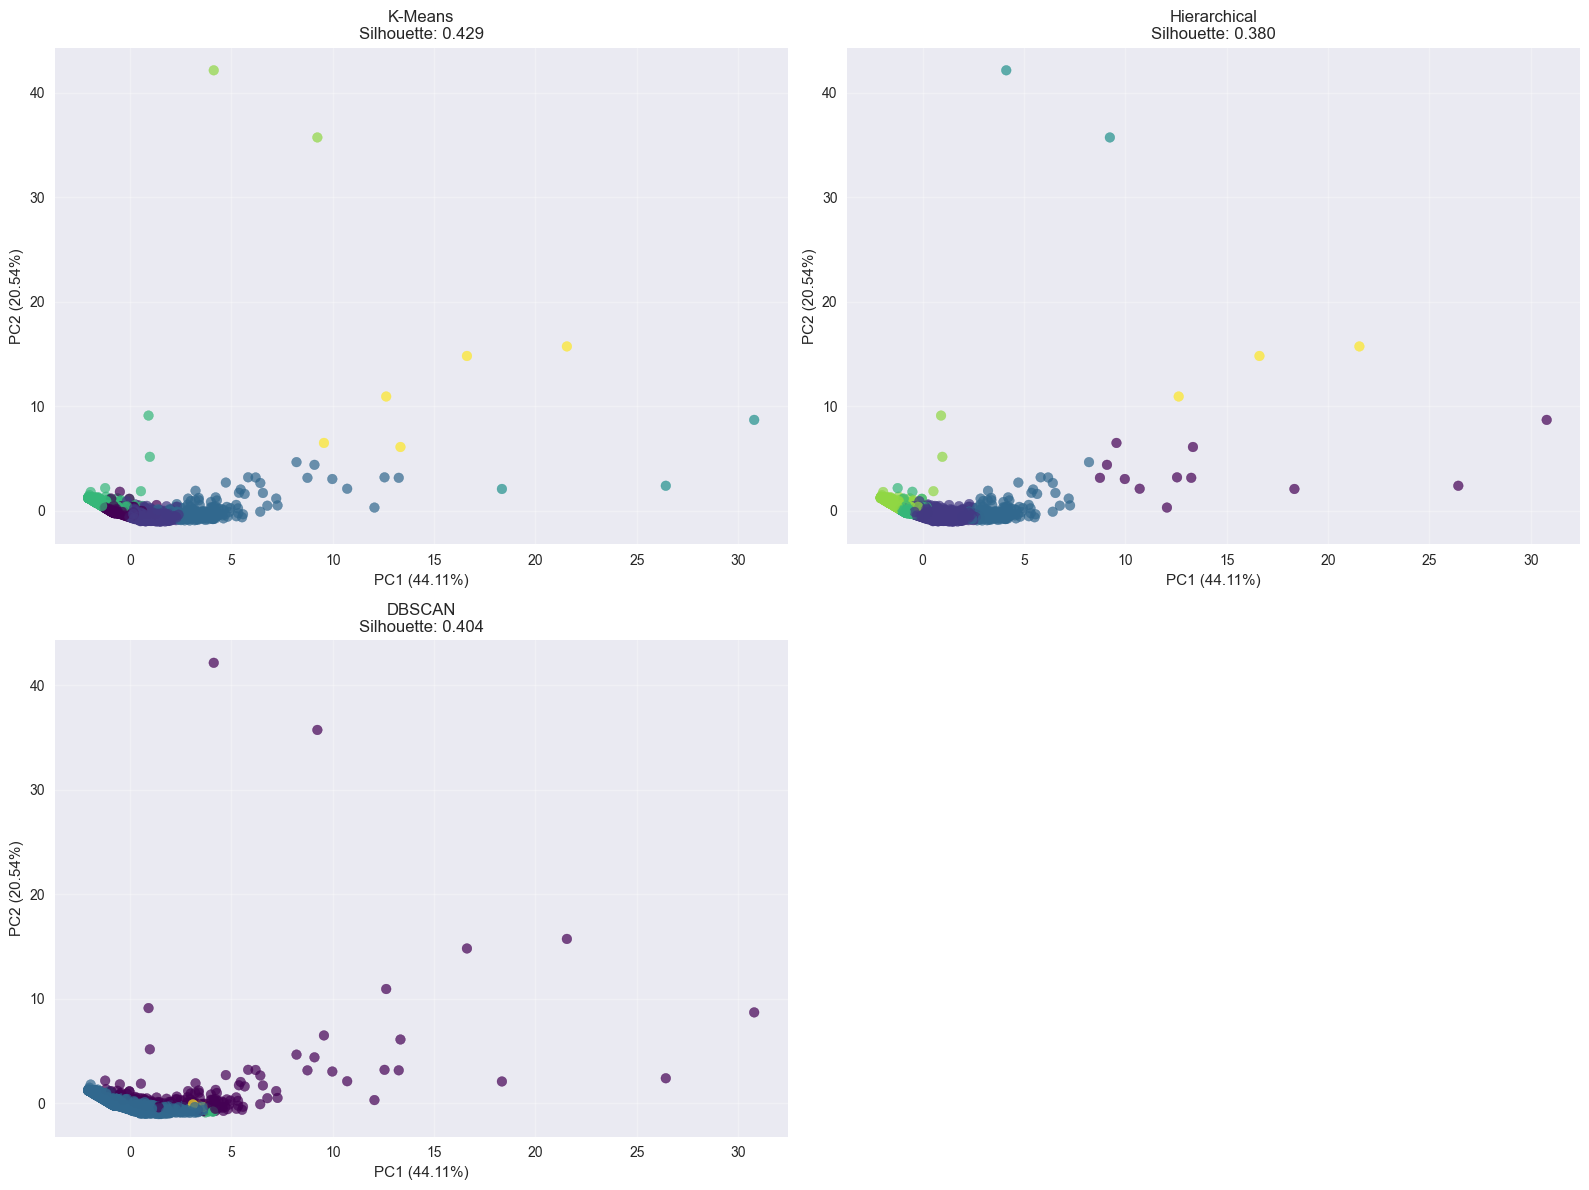

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# PCA for visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plot_idx = 0
for alg_name, results in algorithms_results.items():
    ax = axes[plot_idx // 2, plot_idx % 2]
    
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
                        c=results['labels'], cmap='viridis', alpha=0.7)
    ax.set_title(f'{alg_name}\nSilhouette: {results["silhouette"]:.3f}')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax.grid(True, alpha=0.3)
    
    plot_idx += 1

if len(algorithms_results) < 4:
    fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.savefig('../images/clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.1 Final clustering with the best algorithm (K-Means with optimal number of clusters)

In [18]:
# Final cluster labels
final_labels = algorithms_results[best_algorithm]['labels']

# Add clusters to the original data
X_with_clusters = X.copy()
X_with_clusters['Cluster'] = final_labels

# Clustering quality metrics
silhouette_avg = silhouette_score(X_scaled, final_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, final_labels)

In [19]:
X_with_clusters.head()

,Recency,Frequency,Monetary,AvgOrderValue,NumUniqueProducts,CustomerLifespan,Cluster
0,326,1,77183.60,77183.60,1,0,5
1,2,7,4310.00,23.68,103,365,1
2,75,4,1797.24,57.98,22,282,1
3,19,1,1757.55,24.08,73,0,0
4,310,1,334.40,19.67,17,0,4


## 2.2 Distribution of clients by clusters

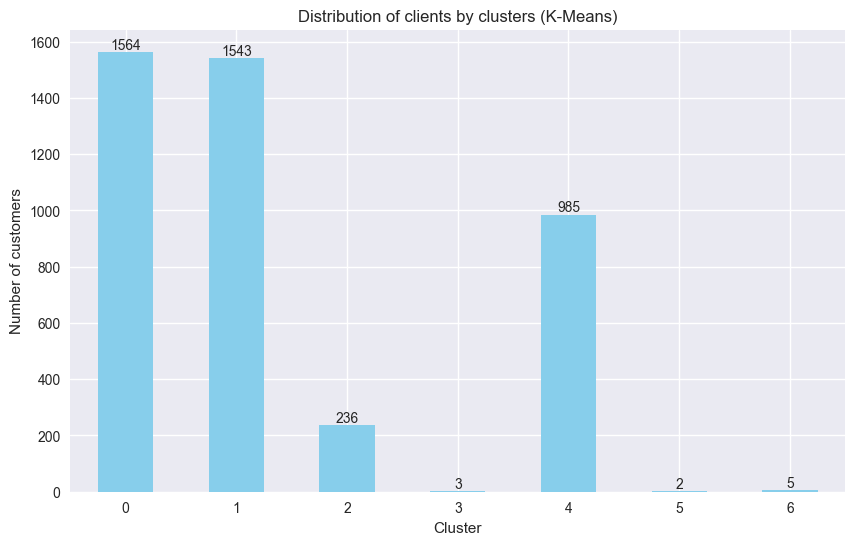

In [20]:
# Distribution of clients by clusters
plt.figure(figsize=(10, 6))
cluster_counts = pd.Series(final_labels).value_counts().sort_index()

cluster_counts.plot(kind='bar', color='skyblue')
plt.title(f'Distribution of clients by clusters ({best_algorithm})')
plt.xlabel('Cluster')
plt.ylabel('Number of customers')
plt.xticks(rotation=0)

for i, v in enumerate(cluster_counts.values):
    plt.text(i, v + 10, str(v), ha='center')

plt.show()

## 2.3 Segment profiling

Profiling in the context of customer clustering or segmentation is the process of describing each cluster by key characteristics to understand who these customers are, how they differ from other groups, and how to work with them.

In [21]:
# Average characteristics by cluster
cluster_profiles = X_with_clusters.groupby('Cluster').agg(['mean', 'std']).round(2)

cluster_sizes = pd.Series(final_labels).value_counts().sort_index()
print(f"Cluster sizes:")
for cluster in sorted(cluster_sizes.index):
    size = cluster_sizes[cluster]
    percentage = (size / len(X_with_clusters)) * 100
    print(f"Cluste {cluster}: {size:,} clients ({percentage:.1f}%)")

print(f"\nCharacteristics of clusters:")
cluster_profiles

Cluster sizes:
Cluste 0: 1,564 clients (36.1%)
Cluste 1: 1,543 clients (35.6%)
Cluste 2: 236 clients (5.4%)
Cluste 3: 3 clients (0.1%)
Cluste 4: 985 clients (22.7%)
Cluste 5: 2 clients (0.0%)
Cluste 6: 5 clients (0.1%)

Characteristics of clusters:


Recency         Frequency          Monetary           AvgOrderValue  \
           mean     std      mean    std       mean       std          mean   
Cluster                                                                       
0         55.56   42.27      1.89   1.24     683.75    881.21         33.43   
1         38.19   35.29      5.50   3.25    2012.35   1884.25         29.23   
2         12.29   15.68     20.42  14.38   11629.68  14262.45         42.00   
3          1.33    0.58    178.00  46.94   72428.07  61845.76         12.71   
4        256.17   62.94      1.51   1.43     536.90   1986.63         55.22   
5        163.50  229.81      1.50   0.71  122828.05  64551.00      66670.55   
6          9.00    9.22     51.00  19.40  195275.74  74839.61        314.99   

                  NumUniqueProducts         CustomerLifespan          
              std              mean     std             mean     std  
Cluster                                                               
0          127.37             35.95   34.37            36.42   50.53  
1           78.97             78.83   53.95           263.68   64.60  
2           92.24            250.68  144.35           327.63   59.26  
3           11.01           1626.00  262.58           371.67    0.58  
4          462.40             23.11   22.84            22.00   44.43  
5        14867.70              2.00    1.41           102.00  144.25  
6          253.70            426.40  285.36           350.40   21.42

## 2.4 Heatmap of cluster characteristics

In [29]:
cluster_means = cluster_profiles.xs('mean', level=1, axis=1)
cluster_means

,Recency,Frequency,Monetary,AvgOrderValue,NumUniqueProducts,CustomerLifespan
Cluster,,,,,,
0,55.56,1.89,683.75,33.43,35.95,36.42
1,38.19,5.50,2012.35,29.23,78.83,263.68
2,12.29,20.42,11629.68,42.00,250.68,327.63
3,1.33,178.00,72428.07,12.71,1626.00,371.67
4,256.17,1.51,536.90,55.22,23.11,22.00
5,163.50,1.50,122828.05,66670.55,2.00,102.00
6,9.00,51.00,195275.74,314.99,426.40,350.40


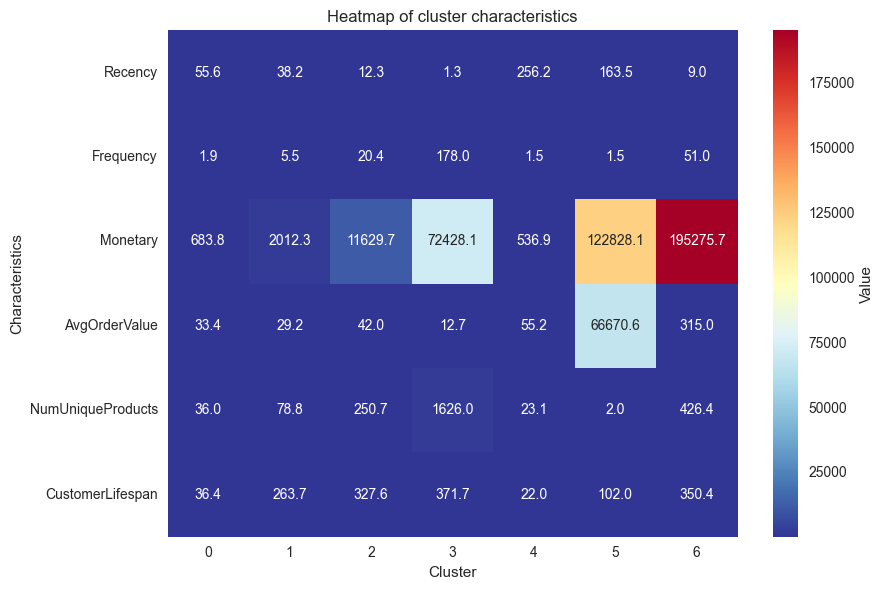

In [ ]:
# Heatmap of cluster characteristics
plt.figure(figsize=(9, 6))
# Take only the average values for the heatmap
cluster_means = cluster_profiles.xs('mean', level=1, axis=1)
sns.heatmap(cluster_means.T, annot=True, cmap='RdYlBu_r', fmt='.1f', cbar_kws={'label': 'Value'})
plt.title('Heatmap of cluster characteristics')
plt.xlabel('Cluster')
plt.ylabel('Characteristics')
plt.tight_layout()
plt.show()

# 3. Saving data

In [23]:
final_clustered = extended_rfm.copy()
final_clustered['Cluster'] = final_labels
final_clustered['Algorithm_Used'] = best_algorithm
final_clustered

,CustomerID,Recency,Frequency,Monetary,NumOrders,NumUniqueProducts,TotalQuantity,AvgQuantity,TotalSpent,AvgOrderValue,StdOrderValue,FirstPurchase,LastPurchase,MainCountry,CustomerLifespan,Cluster,Algorithm_Used
0,12346,326,1,77183.60,1,1,74215,74215.00,77183.60,77183.60,NaN,2011-01-18 10:01:00,2011-01-18 10:01:00,United Kingdom,0,5,K-Means
1,12347,2,7,4310.00,7,103,2458,13.51,4310.00,23.68,23.29,2010-12-07 14:57:00,2011-12-07 15:52:00,Iceland,365,1,K-Means
2,12348,75,4,1797.24,4,22,2341,75.52,1797.24,57.98,48.51,2010-12-16 19:09:00,2011-09-25 13:13:00,Finland,282,1,K-Means
3,12349,19,1,1757.55,1,73,631,8.64,1757.55,24.08,34.66,2011-11-21 09:51:00,2011-11-21 09:51:00,Italy,0,0,K-Means
4,12350,310,1,334.40,1,17,197,11.59,334.40,19.67,7.28,2011-02-02 16:01:00,2011-02-02 16:01:00,Norway,0,4,K-Means
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4333,18280,278,1,180.60,1,10,45,4.50,180.60,18.06,3.38,2011-03-07 09:52:00,2011-03-07 09:52:00,United Kingdom,0,4,K-Means
4334,18281,181,1,80.82,1,7,54,7.71,80.82,11.55,6.11,2011-06-12 10:53:00,2011-06-12 10:53:00,United Kingdom,0,4,K-Means
4335,18282,8,2,178.05,2,12,103,8.58,178.05,14.84,5.85,2011-08-05 13:35:00,2011-12-02 11:43:00,United Kingdom,118,0,K-Means
4336,18283,4,16,2045.53,16,263,1357,1.88,2045.53,2.84,2.59,2011-01-06 14:14:00,2011-12-06 12:02:00,United Kingdom,333,2,K-Means


In [24]:
final_clustered.to_csv('../data/customer_clusters_final.csv', index=False)
comparison_df.to_csv('../data/clustering_algorithms_comparison.csv')